# Installation and import of libraries

In [ ]:
!pip install -U spacy
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 6.6 MB/s eta 0:00:00
  Attempting uninstall: spacy
    Found existing installation: spacy 3.6.1
    Uninstalling spacy-3.6.1:
      Successfully uninstalled spacy-3.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.6.0 requires spacy<3.7.0,>=3.6.0, but you have spacy 3.7.2 which is incompatible.
2024-01-07 14:33:24.099886: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-07 14:33:24.099939: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Att

In [ ]:
!pip install -U spacy
!python -m spacy download en_core_web_md

2024-01-07 14:33:59.924884: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-07 14:33:59.932131: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-07 14:33:59.933833: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-07 14:34:02.559353: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 13.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [ ]:
import pandas as pd
import matplotlib.pyplot as P
import seaborn as sns
import spacy
import re
from wordcloud import WordCloud
from tqdm import tqdm
tqdm.pandas()
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix, classification_report

# Loading data

Loading data containing financial sentences with sentiment labels (negative, neutral, positive).

In [ ]:
data = pd.read_csv('data.csv')
data.sample(5)

,Sentence,Sentiment
572,The corresponding increase in the share capita...,neutral
960,"Bids or offers include at least 1,000 shares a...",neutral
1000,"Ahlstrom Corporation Seppo Parvi , CFO Distrib...",neutral
5392,Union and company officials did not return cal...,neutral
472,"Key price to watch in $NFLX, off the previous ...",negative


The type of data and size in memory.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


Size of the data.

In [ ]:
data.shape

(5842, 2)

In [ ]:
data.describe()

,Sentence,Sentiment
count,5842,5842
unique,5322,3
top,Managing Director 's comments : `` Net sales f...,neutral
freq,2,3130


Counts how many different values are in each column by first using the groupby method to group the data by the labeled column to see how many classes are in the set.

In [ ]:
data.groupby('Sentiment').nunique()

,Sentence
Sentiment,
negative,860
neutral,3124
positive,1852


Distribution of the data

<Axes: xlabel='Sentiment', ylabel='count'>

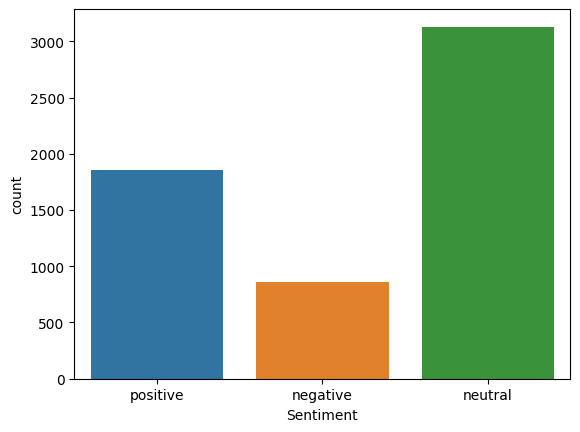

In [ ]:
sns.countplot(x='Sentiment', data=data)

Conclusion: you can see that most of the data is labelled as neutral

Some random examples from each class

In [ ]:
data[data['Sentiment']=='positive'].sample(5)

,Sentence,Sentiment
4029,Bought some more $CELG as it is ready for a bo...,positive
818,Finnish metal products company Componenta Oyj ...,positive
4570,Stora Enso 's third-quarter pre-tax profit dou...,positive
1511,FDA approves Shire's Vyvanse for binge-eating ...,positive
2431,The volumes are expected to increase during th...,positive


In [ ]:
data[data['Sentiment']=='negative'].sample(5)

,Sentence,Sentiment
403,Comparable operating profit totaled EUR 4.7 mn...,negative
831,The measures result from weak demand in the sh...,negative
5134,$GLD http://stks.co/44ow On closer inspection....,negative
4202,The company said that its comparable operating...,negative
761,"$RXII Tang really is toxic, they keep bringing...",negative


In [ ]:
data[data['Sentiment']=='neutral'].sample(5)

,Sentence,Sentiment
2643,Telecom has a foreign investment limit of 74 %...,neutral
325,The record date for dividend distribution is M...,neutral
4849,Iso Omena is based in the Matinkyla district o...,neutral
1716,The reorganisation will be carried out by tran...,neutral
5105,The Tekla Structures 16 installation has been ...,neutral


# Preprocessing

In [ ]:
data['Sentiment'].replace('positive',1,inplace=True)
data['Sentiment'].replace('negative',-1,inplace=True)
data['Sentiment'].replace('neutral',0,inplace=True)
data.sample(5)

,Sentence,Sentiment
665,Commencing the construction works of Pearl Pla...,1
3854,"At 12.01 pm , the OMX Helsinki 25 was down 0.6...",-1
1822,Net profit in the three months through March 3...,-1
5327,$IWM buy programs popping $iwm for close print...,1
985,The casing comprises a first side casing membe...,0


Conversion of all financial sentences in the Sentence column to lowercase letters.

In [ ]:
data['Sentence'] = data['Sentence'].apply(lambda x: x.lower())
data.sample(5)

,Sentence,Sentiment
1516,"finnish exel composites , a technology company...",-1
3973,finnish food company raisio oyj hel : raivv sa...,0
1299,"in finland , insurance company pohjola and the...",1
4258,the elcoteq group recently announced that the ...,0
2480,net sales increased to eur193 .3 m from eur179...,1


Removal of all URLs

In [ ]:
re_url = re.compile(r"((www.[^\s]+)|(https?://[^\s]+))")

data['Sentence'] = data['Sentence'].apply(lambda x: re_url.sub('', x))

Removal of characters from the text except: letters of the alphabet, whitespace characters and apostrophe.

In [ ]:
re_letters = re.compile(r"[^a-z\s']")

data['Sentence'] = data['Sentence'].apply(lambda x: re_letters.sub('', x))
data.sample(5)

,Sentence,Sentiment
4907,shareholder 's full name and id code petri a...,0
3833,finnish construction company yit is reducing t...,-1
2546,dopplr members share personal and business tra...,0
787,comptel a vendor of dynamic operations suppor...,1
2961,finnish metso paper has won an order to supply...,1


Load en_core_web_md model from spacy library.

In [ ]:
nlp = spacy.load('en_core_web_md', disable=['ner', 'parser'])
nlp.add_pipe('sentencizer')

In [ ]:
nlp.Defaults.stop_words

{"'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'could',
 'did',
 'do',
 'does',
 'doing',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fifty',
 'first',
 'five',
 'for',
 'former',
 'formerly',
 'forty',
 'four',
 'from',
 'fron

Removal of stop words

In [ ]:
def remove_stopwords(text):
  return ' '.join(filter(lambda x: x not in nlp.Defaults.stop_words, text.split()))

data['Sentence'] = data['Sentence'].apply(remove_stopwords)
data.sample(5)

,Sentence,Sentiment
306,fda approves astrazeneca drug advanced lung ca...,1
1799,net profit fell half million million end,-1
1252,lsedeutsche brse dealmakers wrong ignore brexi...,-1
1929,januarynovember group sales totalled eur mn dr...,0
1747,operating profit excluding nonrecurring items ...,-1


Removal of duplicates

In [ ]:
data.drop_duplicates(subset='Sentence', keep='first', inplace=True)

Lemantization

In [ ]:
def lemmatize(text):
  return ' '.join([x.lemma_ for x in nlp(text)])

data['Sentence'] = data['Sentence'].progress_apply(lemmatize)
data.sample(10)

100%|██████████| 5245/5245 [00:20<00:00, 260.44it/s]


,Sentence,Sentiment
1221,sink depth metre fix mud vacuum,0
3021,yoku high volume blast friday go high,1
1182,service enable user watch email html format en...,0
4459,press release october ruukki sign contract del...,1
91,tesco share price grocer face sfo investigatio...,-1
1014,choose giant countdown red head rainbow trout ...,0
2611,technopoli finnish operation oulu vantaa espoo...,0
470,measure result decrease demand technical desig...,0
1386,addition company consider start production russia,0
520,offering cover localisation service relate pro...,0


In [ ]:
data['Sequence_Length'] = data['Sentence'].apply(lambda x: len(x.split()))
print(data[data['Sequence_Length'] == 0])

    Sentence  Sentiment  Sequence_Length
497                   0                0


In [ ]:
data = data[data['Sequence_Length'] > 0]

# Word clouds

Display the most popular words from each group

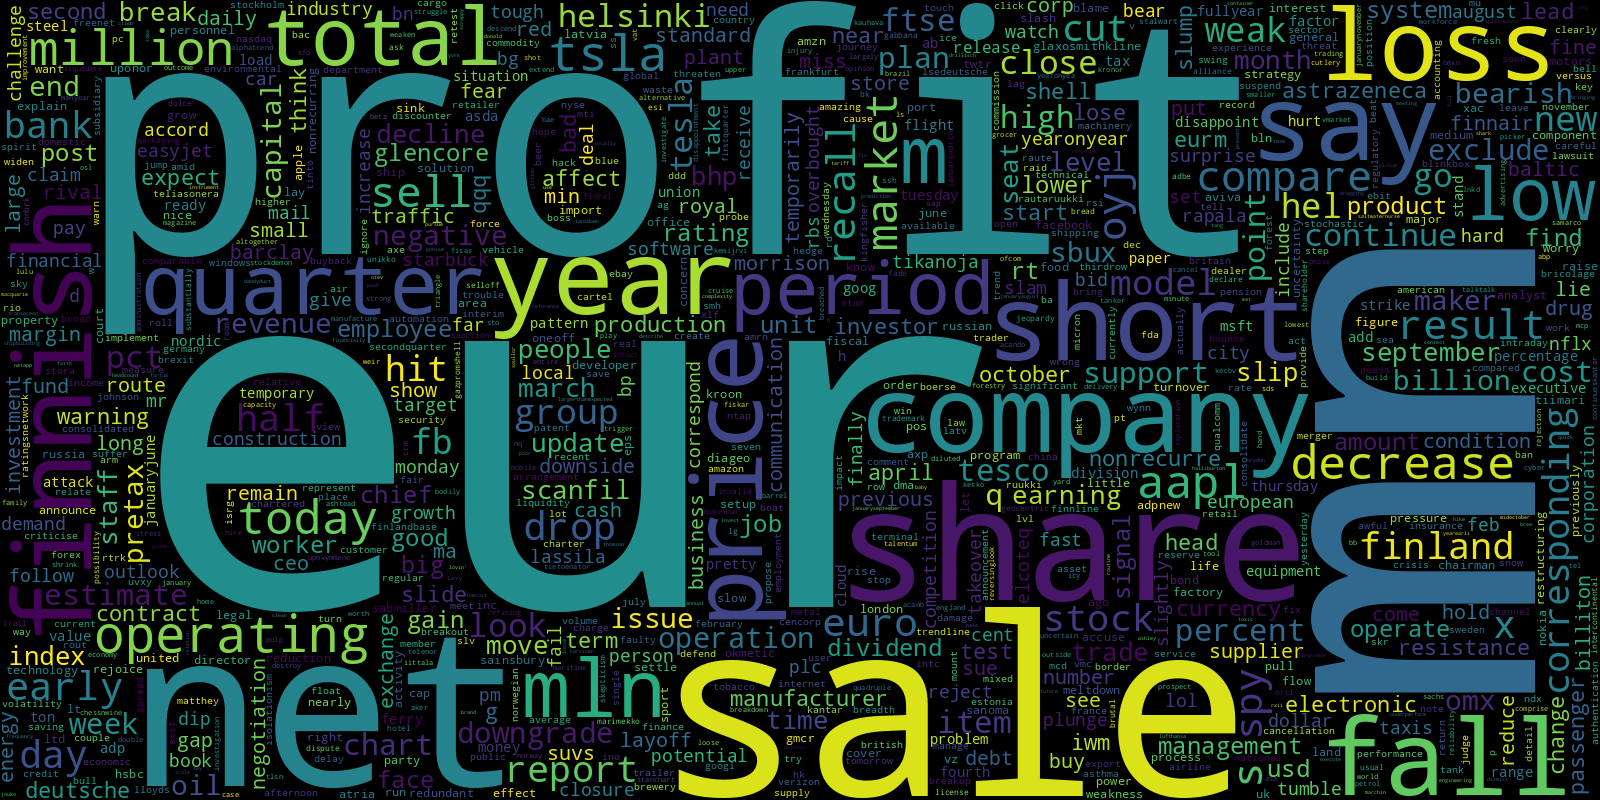

In [ ]:
text_neg = ' '.join(data[data['Sentiment']==-1]['Sentence'])

wc_neg = WordCloud(max_words = 1000, width = 1600, height = 800, collocations=False).generate(text_neg)
wc_neg.to_image()

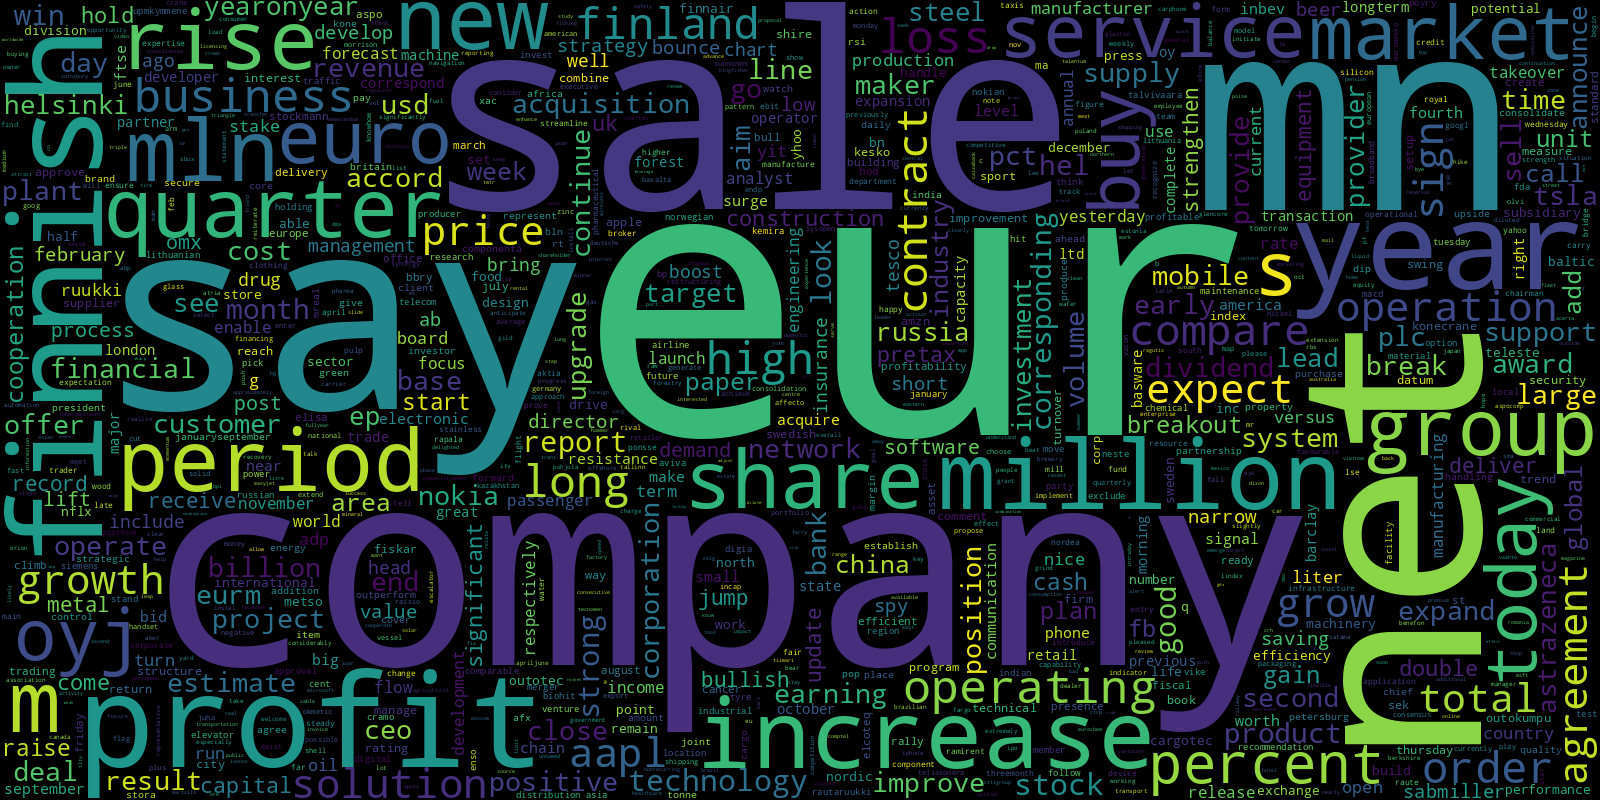

In [ ]:
text_pos = ' '.join(data[data['Sentiment']==1]['Sentence'])

wc_pos = WordCloud(max_words = 1000, width = 1600, height = 800, collocations=False).generate(text_pos)
wc_pos.to_image()

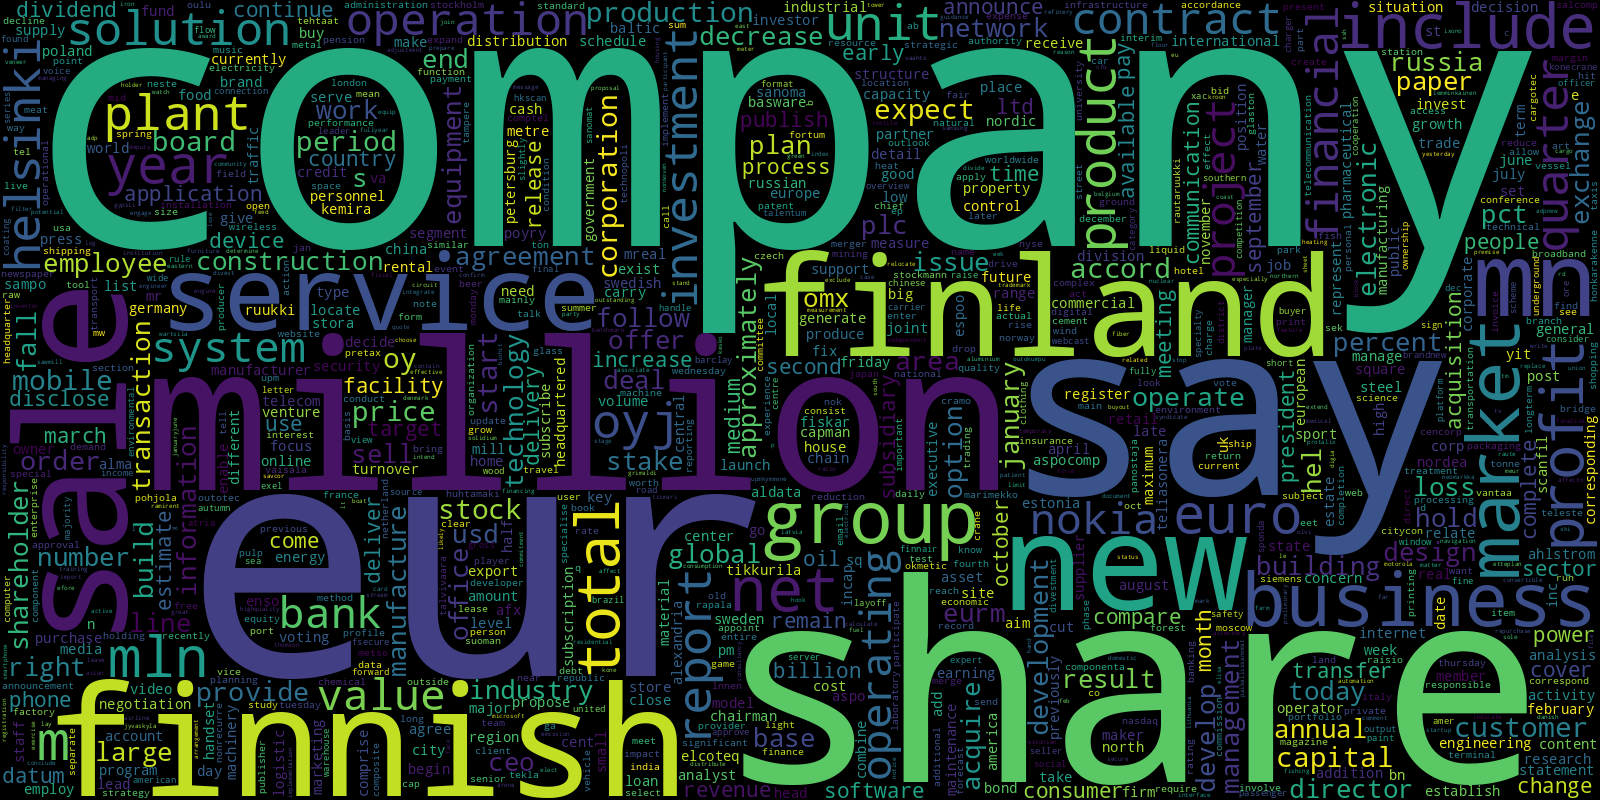

In [ ]:
text_neu = ' '.join(data[data['Sentiment']==0]['Sentence'])

wc_pos = WordCloud(max_words = 1000, width = 1600, height = 800, collocations=False).generate(text_neu)
wc_pos.to_image()

In [ ]:
import pandas as pd
data['combined'] = data['Sentence'].astype(str) + "\t" + data['Sentiment'].astype(str)

data_to_save = data[['combined']]
data_to_save.to_csv('new_data.csv', header=False, index=False)

# LSTM Model using pytorch library

In [ ]:
!pip install torchtext

In [ ]:
from torchtext.data.utils import get_tokenizer
from torch.utils.data import random_split
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torchdata.datapipes as dp
import torch
import torch.nn as nn
import torch.optim as optim
import time

In [ ]:
fpath = 'new_data.csv'
data_pipe = dp.iter.IterableWrapper([fpath])
data_pipe = dp.iter.FileOpener(data_pipe, mode='rb')
data_pipe = data_pipe.parse_csv(skip_lines=0, delimiter='\t', as_tuple=True)

In [ ]:
for sample in data_pipe:
  print(sample)
  break

('geosolution technology leverage benefon gps solution provide location base search technology community platform location relevant multimedia content new powerful commercial model', '1')


In [ ]:
!pip install spacy

In [ ]:
!python -m spacy download en_core_web_sm

2024-01-07 15:39:56.649642: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-07 15:39:56.649701: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-07 15:39:56.651421: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-07 15:39:59.253210: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 22.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
tokenizer = get_tokenizer('spacy', 'en_core_web_sm')

def yield_tokens(data_iter):
  for text, _ in data_iter:
      yield tokenizer(text)

In [ ]:
import random
data_list = list(data_pipe)
random.shuffle(data_list)

split_ratio = 0.8
train_size = int(split_ratio * len(data_list))
train_data = data_list[:train_size]
test_data = data_list[train_size:]

train_iter = iter(train_data)

In [ ]:
MAX_TOKENS = 25000

vocab = build_vocab_from_iterator(
    yield_tokens(train_iter),
    specials=['<unk>'],
    max_tokens=MAX_TOKENS)
vocab.set_default_index(vocab['<unk>'])

In [ ]:
len(vocab)

7822

In [ ]:
vocab(['i', 'say', '-9'])

[1758, 5, 0]

In [ ]:
vocab(['i', 'company', 'share'])

[1758, 2, 6]

In [ ]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: 1 if x == '1' else (-1 if x == '-1' else 0)

In [ ]:
text_pipeline('i share company')

[1758, 6, 2]

In [ ]:
label_pipeline('1')

1

In [ ]:
def collate_batch(batch):
  label_list, text_list, lenghts = [], [], []
  for _text, _label in batch:
    label_list.append(label_pipeline(_label))
    processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
    text_list.append(processed_text)
    lenghts.append(processed_text.size(0))

  label_list = torch.tensor(label_list, dtype=torch.float32)
  lenghts = torch.tensor(lenghts, dtype=torch.int64)
  text_list = pad_sequence(text_list, batch_first=True)
  return label_list, text_list, lenghts

In [ ]:
train_dataset =train_data
test_dataset = test_data

validation_ratio = 0.5
n_test = len(test_dataset)
n_val = int(n_test*validation_ratio)
n_test = n_test-n_val

val_dataset, test_dataset = random_split(test_dataset, [n_val, n_test])

In [ ]:
len(train_dataset)

4195

In [ ]:
BATCH_SIZE = 64
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)

In [ ]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
      super().__init__()
      self.embedding = nn.Embedding(input_dim, embedding_dim)
      self.lstm = nn.LSTM(
          embedding_dim,
          hidden_dim,
          num_layers=3,
          bidirectional=True,
          dropout=0.3
      )
      self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, text, text_length):
      embedded = self.embedding(text)
      packed_embedded = pack_padded_sequence(embedded, text_length.cpu(), batch_first=True, enforce_sorted=False)
      packed_output, (hidden, _) = self.lstm(packed_embedded)
      hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)

      return self.fc(hidden.squeeze(0))

In [ ]:
INPUT_DIM = len(vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1

model_lstm = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

In [ ]:
def count_parameters(model):
  return sum(p.numel() for p in model_lstm.parameters() if p.requires_grad)
print(f'Model ma {count_parameters(model_lstm):,} parametrów')

Model ma 4,669,817 parametrów


In [ ]:
optimizer = optim.SGD(model_lstm.parameters(), lr=1e-3)

In [ ]:
criterion = nn.BCEWithLogitsLoss()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model_lstm.to(device)
criterion = criterion.to(device)

In [ ]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def train(model, dataloader, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for batch in dataloader:
      labels, texts, lengths = batch
      texts, labels = texts.to(device), labels.to(device)
      optimizer.zero_grad()

      predictions = model(texts, lengths).squeeze(1)
      loss = criterion(predictions, labels.float())
      acc = binary_accuracy(predictions, labels)

      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      epoch_acc += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [ ]:
def evaluate(model, dataloader, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()

    with torch.no_grad():
      for batch in dataloader:
        labels, texts, lengths = batch
        texts, labels = texts.to(device), labels.to(device)

        predictions = model(texts, lengths).squeeze(1)
        loss = criterion(predictions, labels)
        acc = binary_accuracy(predictions, labels)

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 15
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
  start_time = time.time()

  train_loss, train_acc = train(model_lstm, train_dataloader, optimizer, criterion)
  valid_loss, valid_acc = evaluate(model_lstm, test_dataloader, criterion)

  end_time = time.time()

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model_lstm.state_dict(), 'rnn_model.pt')

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\t Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 1s
	Train Loss: 0.682 | Train Acc: 53.47%
	 Val. Loss: 0.674 | Val. Acc: 55.45%
Epoch: 02 | Epoch Time: 0m 1s
	Train Loss: 0.675 | Train Acc: 53.47%
	 Val. Loss: 0.666 | Val. Acc: 55.45%
Epoch: 03 | Epoch Time: 0m 1s
	Train Loss: 0.669 | Train Acc: 53.39%
	 Val. Loss: 0.658 | Val. Acc: 55.45%
Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 0.664 | Train Acc: 53.39%
	 Val. Loss: 0.651 | Val. Acc: 55.45%
Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 0.658 | Train Acc: 53.33%
	 Val. Loss: 0.644 | Val. Acc: 55.45%
Epoch: 06 | Epoch Time: 0m 1s
	Train Loss: 0.653 | Train Acc: 53.45%
	 Val. Loss: 0.637 | Val. Acc: 55.45%
Epoch: 07 | Epoch Time: 0m 1s
	Train Loss: 0.648 | Train Acc: 53.45%
	 Val. Loss: 0.631 | Val. Acc: 55.45%
Epoch: 08 | Epoch Time: 0m 1s
	Train Loss: 0.643 | Train Acc: 53.47%
	 Val. Loss: 0.625 | Val. Acc: 55.45%
Epoch: 09 | Epoch Time: 0m 2s
	Train Loss: 0.639 | Train Acc: 53.39%
	 Val. Loss: 0.619 | Val. Acc: 55.45%
Epoch: 10 | Epoch Time: 0m 2s
	Train 

Function designed to classify whether a given input text is negative, positive or neutral, using a trained LSTM text classification model

In [ ]:
def sentiment analysis(model, zdanie, tokenizer, vocab, max_length, device):
    model.eval()

    tokens = tokenizer(zdanie)
    if len(tokens) < max_length:
        tokens.extend(['<pad>'] * (max_length - len(tokens)))
    else:
        tokens = tokens[:max_length]
    token_indices = [vocab[token] if token in vocab else vocab['<unk>'] for token in tokens]

    text_tensor = torch.LongTensor(token_indices).unsqueeze(1).to(device)
    length_tensor = torch.LongTensor([len(token_indices)]).to(device)

    with torch.no_grad():
        predykcja = model(text_tensor, length_tensor)
        predykcja = torch.sigmoid(predykcja).item()

    if predykcja >= 0.5:
        sentyment = 'Positive'
    else:
        sentyment = 'Negative'

    return f"Sentiment of the text: {sentyment}"

# Model RNN with a base of pre-trained word embeddings using pytorch library



In [ ]:
import torch

SEED = 42

# seed dla PyTorch
torch.manual_seed(SEED)
if torch.cuda.is_available():
 torch.cuda.manual_seed(SEED)
 torch.cuda.manual_seed_all(SEED)
 torch.backends.cudnn.deterministic = True
 torch.backends.cudnn.benchmark = False

In [ ]:
!pip install transformers -q

In [ ]:
from transformers import DistilBertTokenizer, DistilBertModel
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import time

In [ ]:
import csv

def read_tsv(filename):
 data = []

 with open(filename, 'r', encoding='utf-8') as f:
  reader = csv.reader(f, delimiter='\t')
  for row in reader:
    data.append(tuple(row))

 return data

filename = "new_data.csv"
data_list = read_tsv(filename)
data_list[0]

('geosolution technology leverage benefon gps solution provide location base search technology community platform location relevant multimedia content new powerful commercial model',
 '1')

In [ ]:
import random
data_list = list(data_pipe)
random.shuffle(data_list)

split_ratio = 0.8
train_size = int(split_ratio * len(data_list))
train_data = data_list[:train_size]
test_data = data_list[train_size:]

train_iter = iter(train_data)

In [ ]:
train_dataset =train_data
test_dataset = test_data

validation_ratio = 0.5
n_test = len(test_dataset)
n_val = int(n_test*validation_ratio)
n_test = n_test-n_val

val_dataset, test_dataset = random_split(test_dataset, [n_val, n_test])

In [ ]:
BATCH_SIZE = 64
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)

In [ ]:
label_pipeline = lambda x: 1 if x == '1' else 0

def collate_batch(batch):
 label_list, text_list = [], []
 for (_text, _label) in batch:
  label_list.append(label_pipeline(_label))
  text_list.append(_text)
 return torch.tensor(label_list, dtype=torch.float32), text_list

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch

class RNN(nn.Module):

  def __init__(self, hidden_dim, output_dim):
    super().__init__()

    self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')

    embedding_dim = self.distilbert.config.hidden_size

    self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, text, text_length=None):
    inputs = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512, return_length=True)
    attention_mask = inputs['attention_mask'].to(device)
    input_ids = inputs['input_ids'].to(device)

    with torch.no_grad():
      embedded = self.distilbert(input_ids, attention_mask=attention_mask).last_hidden_state

    outputs, hidden = self.rnn(embedded)
    return self.fc(hidden.squeeze(0))

In [ ]:
hidden_dim = 256
output_dim = 1

model_rnn = RNN(hidden_dim, output_dim)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
def count_parameters(model):
 return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Model ma {count_parameters(model_rnn):,} parametrów')

Model ma 66,625,793 parametrów


In [ ]:
optimizer = optim.SGD(model_rnn.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()
model_rnn = model_rnn.to(device)
criterion = criterion.to(device)

In [ ]:
def binary_accuracy(preds, y):
  rounded_preds = torch.round(torch.sigmoid(preds))
  correct = (rounded_preds == y).float()
  acc = correct.sum() / len(correct)
  return acc

def train(model, iterator, optimizer, criterion):
  epoch_loss = 0
  epoch_acc = 0
  model.train()

  for batch in iterator:
    labels, texts = batch
    labels = labels.to(device)
    optimizer.zero_grad()

    predictions = model(texts).squeeze(1)
    loss = criterion(predictions, labels)
    acc = binary_accuracy(predictions, labels)

    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
  epoch_loss = 0
  epoch_acc = 0
  model.eval()

  with torch.no_grad():
    for batch in iterator:
      labels, texts = batch
      labels = labels.to(device)

      predictions = model(texts).squeeze(1)
      loss = criterion(predictions, labels)
      acc = binary_accuracy(predictions, labels)

      epoch_loss += loss.item()
      epoch_acc += acc.item()

  return epoch_loss / len(iterator), epoch_acc / len(iterator)

def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 15
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
  start_time = time.time()

  train_loss, train_acc = train(model_rnn, train_dataloader, optimizer, criterion)
  valid_loss, valid_acc = evaluate(model_rnn, val_dataloader, criterion)

  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model_rnn.state_dict(), 'rnn-model.pt')

  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\t Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 7s
	Train Loss: 0.675 | Train Acc: 62.34%
	 Val. Loss: 0.682 | Val. Acc: 57.47%
Epoch: 02 | Epoch Time: 0m 6s
	Train Loss: 0.656 | Train Acc: 65.43%
	 Val. Loss: 0.681 | Val. Acc: 58.74%
Epoch: 03 | Epoch Time: 0m 9s
	Train Loss: 0.649 | Train Acc: 65.70%
	 Val. Loss: 0.684 | Val. Acc: 58.74%
Epoch: 04 | Epoch Time: 0m 7s
	Train Loss: 0.646 | Train Acc: 65.61%
	 Val. Loss: 0.685 | Val. Acc: 58.91%
Epoch: 05 | Epoch Time: 0m 6s
	Train Loss: 0.644 | Train Acc: 65.85%
	 Val. Loss: 0.686 | Val. Acc: 58.91%
Epoch: 06 | Epoch Time: 0m 6s
	Train Loss: 0.644 | Train Acc: 65.79%
	 Val. Loss: 0.687 | Val. Acc: 58.91%
Epoch: 07 | Epoch Time: 0m 6s
	Train Loss: 0.643 | Train Acc: 65.73%
	 Val. Loss: 0.686 | Val. Acc: 58.91%
Epoch: 08 | Epoch Time: 0m 6s
	Train Loss: 0.643 | Train Acc: 65.75%
	 Val. Loss: 0.685 | Val. Acc: 58.91%
Epoch: 09 | Epoch Time: 0m 6s
	Train Loss: 0.643 | Train Acc: 65.73%
	 Val. Loss: 0.685 | Val. Acc: 58.91%
Epoch: 10 | Epoch Time: 0m 6s
	Train 

# CNN Model using tensorflow library

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense, Conv1D, GlobalMaxPooling1D
from keras.initializers import Constant
from tensorflow.keras.utils import to_categorical

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data['Sentence'])
sequences = tokenizer.texts_to_sequences(data['Sentence'])

max_length = max([len(x) for x in sequences])
X = pad_sequences(sequences, maxlen=max_length)
y = pd.get_dummies(data['Sentiment']).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model_cnn = Sequential()
model_cnn.add(Embedding(5000, 128, input_length=max_length))
model_cnn.add(Conv1D(128, 5, activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(3, activation='softmax'))
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model_cnn.fit(X_train, y_train, batch_size=32, epochs=15, validation_data=(X_test, y_test))

Epoch 1/15
132/132 [==============================] - 9s 53ms/step - loss: 0.8788 - accuracy: 0.5931 - val_loss: 0.6855 - val_accuracy: 0.7255
Epoch 2/15
132/132 [==============================] - 2s 18ms/step - loss: 0.4945 - accuracy: 0.8098 - val_loss: 0.5987 - val_accuracy: 0.7626
Epoch 3/15
132/132 [==============================] - 3s 23ms/step - loss: 0.2414 - accuracy: 0.9180 - val_loss: 0.6760 - val_accuracy: 0.7636
Epoch 4/15
132/132 [==============================] - 2s 13ms/step - loss: 0.1184 - accuracy: 0.9628 - val_loss: 0.7839 - val_accuracy: 0.7464
Epoch 5/15
132/132 [==============================] - 1s 10ms/step - loss: 0.0636 - accuracy: 0.9816 - val_loss: 0.8804 - val_accuracy: 0.7579
Epoch 6/15
132/132 [==============================] - 1s 7ms/step - loss: 0.0436 - accuracy: 0.9855 - val_loss: 0.9218 - val_accuracy: 0.7512
Epoch 7/15
132/132 [==============================] - 1s 7ms/step - loss: 0.0349 - accuracy: 0.9888 - val_loss: 1.0008 - val_accuracy: 0.7569
E

# Model with fine-tuning of the language model (RoBERT) using tensorflow library

In [ ]:
!pip install transformers

In [ ]:
from transformers import RobertaTokenizer, TFRobertaModel
from keras.layers import Input, Dropout, Dense
from keras.models import Model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense, Conv1D, GlobalMaxPooling1D, Input, Dropout
from keras.initializers import Constant
from tensorflow.keras.utils import to_categorical
from transformers import RobertaTokenizer, TFRobertaModel

In [ ]:
tokenizer_cnn = Tokenizer(num_words=5000)
tokenizer_cnn.fit_on_texts(data['Sentence'])
sequences = tokenizer_cnn.texts_to_sequences(data['Sentence'])

max_length_cnn = max([len(x) for x in sequences])
X_cnn = pad_sequences(sequences, maxlen=max_length_cnn)
y = pd.get_dummies(data['Sentiment']).values

X_train_cnn, X_test_cnn, y_train, y_test = train_test_split(X_cnn, y, test_size=0.2, random_state=42)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42)

train_indices = X_train.index
test_indices = X_test.index

X_cnn = pad_sequences(tokenizer_cnn.texts_to_sequences(X_train['Sentence']), maxlen=max_length_cnn)
X_test_cnn = pad_sequences(tokenizer_cnn.texts_to_sequences(X_test['Sentence']), maxlen=max_length_cnn)

In [ ]:
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

def tokenize_roberta(texts, tokenizer, max_length):
    return tokenizer(texts.tolist(), padding='max_length', truncation=True, max_length=max_length, return_tensors='tf')

max_length_roberta = 128
X_roberta = tokenize_roberta(data['Sentence'], roberta_tokenizer, max_length_roberta)

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42)

train_indices = X_train.index
test_indices = X_test.index

X_cnn = pad_sequences(tokenizer_cnn.texts_to_sequences(X_train['Sentence']), maxlen=max_length_cnn)
X_test_cnn = pad_sequences(tokenizer_cnn.texts_to_sequences(X_test['Sentence']), maxlen=max_length_cnn)

X_roberta_train = tokenize_roberta(X_train['Sentence'], roberta_tokenizer, max_length_roberta)
X_roberta_test = tokenize_roberta(X_test['Sentence'], roberta_tokenizer, max_length_roberta)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
import tensorflow as tf

def tokenize_roberta(texts, tokenizer, max_length):
    tokens = tokenizer(texts.tolist(), padding='max_length', truncation=True, max_length=max_length, return_tensors='tf')
    return {'input_ids': tf.convert_to_tensor(tokens['input_ids'], dtype=tf.int32),
            'attention_mask': tf.convert_to_tensor(tokens['attention_mask'], dtype=tf.int32)}


In [ ]:
X_roberta_train = tokenize_roberta(X_train['Sentence'], roberta_tokenizer, max_length_roberta)
X_roberta_test = tokenize_roberta(X_test['Sentence'], roberta_tokenizer, max_length_roberta)

In [ ]:
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

input_ids = Input(shape=(max_length_roberta,), dtype='int32', name='input_ids')
attention_mask = Input(shape=(max_length_roberta,), dtype='int32', name='attention_mask')

roberta_output = roberta_model(input_ids=input_ids, attention_mask=attention_mask)[1]
dropout = Dropout(0.2)(roberta_output)
output = Dense(3, activation='softmax')(dropout)

model_roberta = Model(inputs=[input_ids, attention_mask], outputs=output)
model_roberta.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'roberta.embeddings.position_ids', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [ ]:
model_roberta.fit(X_roberta_train, y_train, batch_size=32, epochs=3, validation_data=(X_roberta_test, y_test))

Epoch 1/3
132/132 [==============================] - 180s 925ms/step - loss: 1.0676 - accuracy: 0.5077 - val_loss: 1.0026 - val_accuracy: 0.5357
Epoch 2/3
132/132 [==============================] - 113s 860ms/step - loss: 0.9753 - accuracy: 0.5280 - val_loss: 0.9965 - val_accuracy: 0.3499
Epoch 3/3
132/132 [==============================] - 114s 863ms/step - loss: 0.9726 - accuracy: 0.5218 - val_loss: 1.0214 - val_accuracy: 0.5357


In [ ]:
def rating_text(model, tekst):
    seq = tokenizer.texts_to_sequences([tekst])
    padded = pad_sequences(seq, maxlen=max_length)
    pred = model.predict(padded)
    klasy = ['Negative', 'Neutral', 'Positive']
    return f"Sentiment of the text: {klasy[np.argmax(pred)]}"

In [ ]:
text = "it's normal"
rating_text(model_cnn, text)

1/1 [==============================] - 0s 31ms/step


'Sentymencik tekstu: Neutralny'

In [ ]:
def tokenize_roberta(texts, tokenizer, max_length):
    if not isinstance(texts, list):
        texts = [texts]
    tokens = tokenizer(texts, padding='max_length', truncation=True, max_length=max_length, return_tensors='tf')
    return {'input_ids': tokens['input_ids'], 'attention_mask': tokens['attention_mask']}


In [ ]:
def sentiment_analysis(model, tokenizer, tekst, max_length):
    tokenized_text = tokenize_roberta(tekst, tokenizer, max_length)
    predict = model.predict(tokenized_text)
    class_sentiment = ['Negative', 'Neutral', 'Positive']
    sentiment = class_sentiment[np.argmax(predict)]

    return f"Sentiment of the text: {sentiment}"


In [ ]:
result = sentiment_analysis(model_roberta, roberta_tokenizer, text, max_length_roberta)
print(result)

1/1 [==============================] - 6s 6s/step
Sentyment tekstu: Neutralny
